<a href="https://colab.research.google.com/github/madhapriya/quantum-chemistry/blob/main/quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --force-reinstall "h5py>=3.8.0" pennylane pennylane-qchem scipy numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pennylane-qchem to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB

Number of qubits: 4
Number of Hamiltonian terms: 15
Tracked Energy: -1.116759
Step 0, Params norm: 0.018121
Step 0: Energy = -1.116759 Hartree
Tracked Energy: -1.119913
Tracked Energy: -1.122587
Tracked Energy: -1.124853
Tracked Energy: -1.126772
Tracked Energy: -1.128397
Tracked Energy: -1.129772
Tracked Energy: -1.130935
Tracked Energy: -1.131918
Tracked Energy: -1.132750
Tracked Energy: -1.133453
Step 10, Params norm: 0.136153
Step 10: Energy = -1.133453 Hartree
Tracked Energy: -1.134047
Tracked Energy: -1.134550
Tracked Energy: -1.134974
Tracked Energy: -1.135333
Tracked Energy: -1.135636
Tracked Energy: -1.135892
Tracked Energy: -1.136108
Tracked Energy: -1.136291
Tracked Energy: -1.136445
Tracked Energy: -1.136575
Step 20, Params norm: 0.187131
Step 20: Energy = -1.136575 Hartree
Tracked Energy: -1.136685
Tracked Energy: -1.136778
Tracked Energy: -1.136857
Tracked Energy: -1.136923
Tracked Energy: -1.136979
Tracked Energy: -1.137027
Tracked Energy: -1.137067
Tracked Energy: -1.13

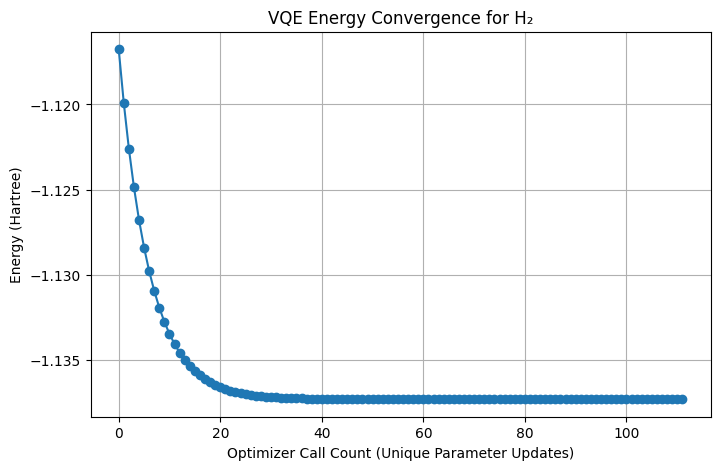

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Constants
ANGSTROM_TO_BOHR = 1.8897259886

# Define H2 molecule symbols and coordinates (converted to Bohr units)
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74 * ANGSTROM_TO_BOHR],  # bond length in Bohr (~0.74 Å)
])

# Create Molecule object with basis set
molecule = qchem.Molecule(
    symbols=symbols,
    coordinates=coordinates,
    charge=0,
    mult=1,
    basis_name="sto-3g"
)

# Number of active electrons and orbitals for H2
active_electrons = 2
active_orbitals = 2

# Build Hamiltonian
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    molecule,
    active_electrons=active_electrons,
    active_orbitals=active_orbitals
)

print("Number of qubits:", num_qubits)
print("Number of Hamiltonian terms:", len(hamiltonian))

# Prepare Hartree-Fock state
hf_state = qchem.hf_state(active_electrons, num_qubits)

# Get single and double excitations
singles, doubles = qchem.excitations(active_electrons, num_qubits)

# Convert excitations to wire format
s_wires, d_wires = qchem.excitations_to_wires(singles, doubles)

# Define quantum device
dev = qml.device("default.qubit", wires=num_qubits)

from pennylane.templates import UCCSD



# Define VQE circuit
@qml.qnode(dev)
def circuit(params):
    UCCSD(params, wires=range(num_qubits), s_wires=s_wires, d_wires=d_wires, init_state=hf_state)
    return qml.expval(hamiltonian)

# Initialize parameters
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
params = np.zeros(len(s_wires) + len(d_wires), requires_grad=True)

# Variables to track energy convergence
previous_params = None
energy_progress = []

def store_intermediate_result(params, energy):
    global previous_params
    if previous_params is None or not np.allclose(previous_params, params):
        energy_progress.append(energy)
        previous_params = params.copy()
        print(f"Tracked Energy: {energy:.6f}")

# Optimization loop with tracking
max_iters = 120
for n in range(max_iters):
    params, energy = optimizer.step_and_cost(circuit, params)
    store_intermediate_result(params, energy)
    if n % 10 == 0:
        print(f"Step {n}, Params norm: {np.linalg.norm(params):.6f}")
        print(f"Step {n}: Energy = {energy:.6f} Hartree")

print("Final VQE energy (Hartree):", energy)

# Exact diagonalization for comparison
Hmat = qml.matrix(hamiltonian)
eigvals, _ = np.linalg.eigh(Hmat)
print("Exact ground state energy (Hartree):", np.min(eigvals))

# Plot energy convergence
plt.figure(figsize=(8, 5))
plt.plot(range(len(energy_progress)), energy_progress, marker='o')
plt.xlabel("Optimizer Call Count (Unique Parameter Updates)")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Energy Convergence for H₂")
plt.grid(True)
plt.show()


In [2]:
!pip install pennylane fastapi uvicorn nest_asyncio pyngrok


In [3]:
from pyngrok import ngrok

NGROK_AUTH = "32SGLpLBOgcnF33mQkZbwFRSYQy_4PRBYDq2xFTPjy7sFKk2k"   # <--- put your token here
ngrok.set_auth_token(NGROK_AUTH)


Number of qubits: 8
Number of Hamiltonian terms: 193
Tracked Energy: -7.861865
Step 0, Params norm: 0.003738
Step 0: Energy = -7.861865 Hartree
Tracked Energy: -7.861995
Tracked Energy: -7.862095
Tracked Energy: -7.862177
Tracked Energy: -7.862246
Tracked Energy: -7.862307
Tracked Energy: -7.862361
Tracked Energy: -7.862410
Tracked Energy: -7.862455
Tracked Energy: -7.862496
Tracked Energy: -7.862534
Step 10, Params norm: 0.027049
Step 10: Energy = -7.862534 Hartree
Tracked Energy: -7.862569
Tracked Energy: -7.862602
Tracked Energy: -7.862632
Tracked Energy: -7.862660
Tracked Energy: -7.862686
Tracked Energy: -7.862710
Tracked Energy: -7.862732
Tracked Energy: -7.862753
Tracked Energy: -7.862772
Tracked Energy: -7.862791
Step 20, Params norm: 0.041925
Step 20: Energy = -7.862791 Hartree
Tracked Energy: -7.862807
Tracked Energy: -7.862823
Tracked Energy: -7.862838
Tracked Energy: -7.862851
Tracked Energy: -7.862864
Tracked Energy: -7.862876
Tracked Energy: -7.862887
Tracked Energy: -7.8

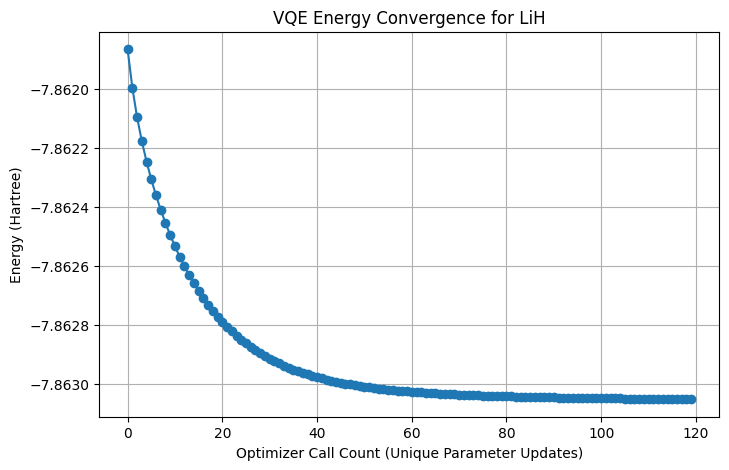

In [5]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Constants
ANGSTROM_TO_BOHR = 1.8897259886

# Define H2 molecule symbols and coordinates (converted to Bohr units)
symbols = ["Li", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 1.6 * ANGSTROM_TO_BOHR],  # bond length in Bohr (~0.74 Å)
])

# Create Molecule object with basis set
molecule = qchem.Molecule(
    symbols=symbols,
    coordinates=coordinates,
    charge=0,
    mult=1,
    basis_name="sto-3g"
)

# Number of active electrons and orbitals for LIH
active_electrons = 4
active_orbitals = 4

# Build Hamiltonian
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    molecule,
    active_electrons=active_electrons,
    active_orbitals=active_orbitals
)

print("Number of qubits:", num_qubits)
print("Number of Hamiltonian terms:", len(hamiltonian))

# Prepare Hartree-Fock state
hf_state = qchem.hf_state(active_electrons, num_qubits)

# Get single and double excitations
singles, doubles = qchem.excitations(active_electrons, num_qubits)

# Convert excitations to wire format
s_wires, d_wires = qchem.excitations_to_wires(singles, doubles)

# Define quantum device
dev = qml.device("default.qubit", wires=num_qubits)

from pennylane.templates import UCCSD



# Define VQE circuit
@qml.qnode(dev)
def circuit(params):
    UCCSD(params, wires=range(num_qubits), s_wires=s_wires, d_wires=d_wires, init_state=hf_state)
    return qml.expval(hamiltonian)

# Initialize parameters
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
params = np.zeros(len(s_wires) + len(d_wires), requires_grad=True)

# Variables to track energy convergence
previous_params = None
energy_progress = []

def store_intermediate_result(params, energy):
    global previous_params
    if previous_params is None or not np.allclose(previous_params, params):
        energy_progress.append(energy)
        previous_params = params.copy()
        print(f"Tracked Energy: {energy:.6f}")

# Optimization loop with tracking
max_iters = 120
for n in range(max_iters):
    params, energy = optimizer.step_and_cost(circuit, params)
    store_intermediate_result(params, energy)
    if n % 10 == 0:
        print(f"Step {n}, Params norm: {np.linalg.norm(params):.6f}")
        print(f"Step {n}: Energy = {energy:.6f} Hartree")

print("Final VQE energy (Hartree):", energy)

# Exact diagonalization for comparison
Hmat = qml.matrix(hamiltonian)
eigvals, _ = np.linalg.eigh(Hmat)
print("Exact ground state energy (Hartree):", np.min(eigvals))

# Plot energy convergence
plt.figure(figsize=(8, 5))
plt.plot(range(len(energy_progress)), energy_progress, marker='o')
plt.xlabel("Optimizer Call Count (Unique Parameter Updates)")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Energy Convergence for LiH")
plt.grid(True)
plt.show()


 **TwoLocal Ansatz**

In [6]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Constants
ANGSTROM_TO_BOHR = 1.8897259886

# Define H2 molecule
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74 * ANGSTROM_TO_BOHR],
])

# Molecule object
molecule = qchem.Molecule(symbols, coordinates, charge=0, mult=1, basis_name="sto-3g")

# Active space
active_electrons = 2
active_orbitals = 2

# Hamiltonian
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    molecule, active_electrons=active_electrons, active_orbitals=active_orbitals
)

print("Number of qubits:", num_qubits)

# HF state
hf_state = qchem.hf_state(active_electrons, num_qubits)

# Device
dev = qml.device("default.qubit", wires=num_qubits)

# TwoLocal equivalent ansatz
def two_local_ansatz(params, wires):
    layers = len(params) // (2 * len(wires))
    params = params.reshape(layers, 2, len(wires))
    for l in range(layers):
        # Rotation layer
        for w in wires:
            qml.RY(params[l,0,w], wires=w)
            qml.RZ(params[l,1,w], wires=w)
        # Entangling layer (ring entanglement)
        for w in range(len(wires)):
            qml.CNOT(wires=[w, (w+1) % len(wires)])

@qml.qnode(dev)
def circuit(params):
    qml.BasisState(hf_state, wires=range(num_qubits))
    two_local_ansatz(params, wires=range(num_qubits))
    return qml.expval(hamiltonian)

# Parameters
layers = 3
params = np.random.normal(0, 0.1, size=(layers*2*num_qubits), requires_grad=True)

# Optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.1)
energy_progress = []

for n in range(120):
    params, energy = opt.step_and_cost(circuit, params)
    energy_progress.append(energy)
    if n % 10 == 0:
        print(f"[TwoLocal] Step {n}: Energy = {energy:.6f} Hartree")

print("Final TwoLocal VQE energy:", energy)


Number of qubits: 4
[TwoLocal] Step 0: Energy = -0.432753 Hartree
[TwoLocal] Step 10: Energy = -0.441211 Hartree
[TwoLocal] Step 20: Energy = -0.445568 Hartree
[TwoLocal] Step 30: Energy = -0.449203 Hartree
[TwoLocal] Step 40: Energy = -0.454270 Hartree
[TwoLocal] Step 50: Energy = -0.463159 Hartree
[TwoLocal] Step 60: Energy = -0.479535 Hartree
[TwoLocal] Step 70: Energy = -0.509138 Hartree
[TwoLocal] Step 80: Energy = -0.559559 Hartree
[TwoLocal] Step 90: Energy = -0.636816 Hartree
[TwoLocal] Step 100: Energy = -0.737862 Hartree
[TwoLocal] Step 110: Energy = -0.846695 Hartree
Final TwoLocal VQE energy: -0.9353417857755357


Number of qubits: 4
Number of Hamiltonian terms: 15
Tracked Energy: -0.435864
[TwoLocal] Step 0: Energy = -0.435864 Hartree
Tracked Energy: -0.437082
Tracked Energy: -0.438234
Tracked Energy: -0.439326
Tracked Energy: -0.440366
Tracked Energy: -0.441358
Tracked Energy: -0.442310
Tracked Energy: -0.443226
Tracked Energy: -0.444112
Tracked Energy: -0.444972
Tracked Energy: -0.445812
[TwoLocal] Step 10: Energy = -0.445812 Hartree
Tracked Energy: -0.446635
Tracked Energy: -0.447448
Tracked Energy: -0.448252
Tracked Energy: -0.449053
Tracked Energy: -0.449855
Tracked Energy: -0.450662
Tracked Energy: -0.451477
Tracked Energy: -0.452304
Tracked Energy: -0.453148
Tracked Energy: -0.454012
[TwoLocal] Step 20: Energy = -0.454012 Hartree
Tracked Energy: -0.454899
Tracked Energy: -0.455815
Tracked Energy: -0.456762
Tracked Energy: -0.457745
Tracked Energy: -0.458768
Tracked Energy: -0.459835
Tracked Energy: -0.460950
Tracked Energy: -0.462118
Tracked Energy: -0.463343
Tracked Energy: -0.464630
[T

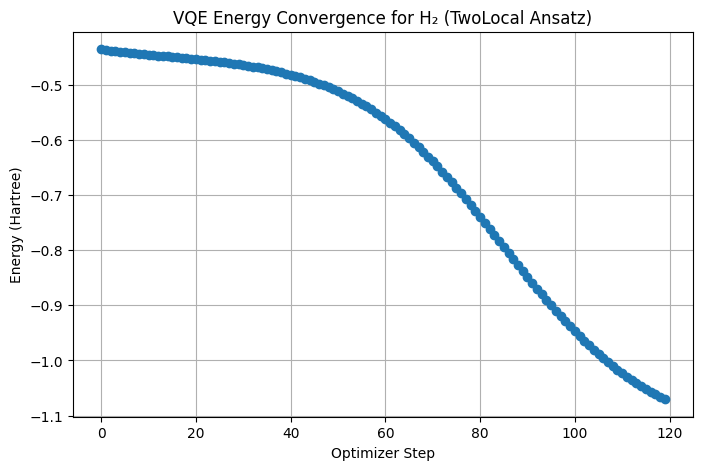

In [8]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

# === Molecule Setup ===
ANGSTROM_TO_BOHR = 1.8897259886
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74 * ANGSTROM_TO_BOHR],  # 0.74 Å
])
molecule = qchem.Molecule(symbols, coordinates, charge=0, mult=1, basis_name="sto-3g")

active_electrons = 2
active_orbitals = 2

hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    molecule, active_electrons=active_electrons, active_orbitals=active_orbitals
)
print("Number of qubits:", num_qubits)
print("Number of Hamiltonian terms:", len(hamiltonian))

hf_state = qchem.hf_state(active_electrons, num_qubits)

# === Quantum Device ===
dev = qml.device("default.qubit", wires=num_qubits)

# === TwoLocal Ansatz ===
def two_local_ansatz(params, wires):
    layers = len(params) // (2 * len(wires))
    params = params.reshape(layers, 2, len(wires))
    for l in range(layers):
        # Rotation layer
        for w in wires:
            qml.RY(params[l,0,w], wires=w)
            qml.RZ(params[l,1,w], wires=w)
        # Ring entanglement
        for w in range(len(wires)):
            qml.CNOT(wires=[w, (w+1) % len(wires)])

@qml.qnode(dev)
def circuit(params):
    qml.BasisState(hf_state, wires=range(num_qubits))
    two_local_ansatz(params, wires=range(num_qubits))
    return qml.expval(hamiltonian)

# === Optimization ===
layers = 3
params = np.random.normal(0, 0.1, size=(layers*2*num_qubits), requires_grad=True)

optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
energy_progress = []

def store_intermediate_result(params, energy):
    energy_progress.append(energy)
    print(f"Tracked Energy: {energy:.6f}")

max_iters = 120
for n in range(max_iters):
    params, energy = optimizer.step_and_cost(circuit, params)
    store_intermediate_result(params, energy)
    if n % 10 == 0:
        print(f"[TwoLocal] Step {n}: Energy = {energy:.6f} Hartree")

print("Final TwoLocal VQE energy (Hartree):", energy)

# === Exact Diagonalization ===
Hmat = qml.matrix(hamiltonian)
eigvals, _ = np.linalg.eigh(Hmat)
print("Exact ground state energy (Hartree):", np.min(eigvals))

# === Plot Convergence ===
plt.figure(figsize=(8, 5))
plt.plot(range(len(energy_progress)), energy_progress, marker='o')
plt.xlabel("Optimizer Step")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Energy Convergence for H₂ (TwoLocal Ansatz)")
plt.grid(True)
plt.show()


EfficientSU2 Ansatz

In [7]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Constants
ANGSTROM_TO_BOHR = 1.8897259886

# Define H2 molecule
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74 * ANGSTROM_TO_BOHR],
])

# Molecule object
molecule = qchem.Molecule(symbols, coordinates, charge=0, mult=1, basis_name="sto-3g")

# Active space
active_electrons = 2
active_orbitals = 2

# Hamiltonian
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    molecule, active_electrons=active_electrons, active_orbitals=active_orbitals
)

print("Number of qubits:", num_qubits)

# HF state
hf_state = qchem.hf_state(active_electrons, num_qubits)

# Device
dev = qml.device("default.qubit", wires=num_qubits)

# EfficientSU2 equivalent ansatz
def efficient_su2_ansatz(params, wires):
    layers = len(params) // len(wires)
    params = params.reshape(layers, len(wires))
    for l in range(layers):
        # Rotation layer
        for w in wires:
            qml.RY(params[l,w], wires=w)
        # Entanglement (linear)
        for w in range(len(wires)-1):
            qml.CNOT(wires=[w, w+1])

@qml.qnode(dev)
def circuit(params):
    qml.BasisState(hf_state, wires=range(num_qubits))
    efficient_su2_ansatz(params, wires=range(num_qubits))
    return qml.expval(hamiltonian)

# Parameters
layers = 3
params = np.random.normal(0, 0.1, size=(layers*num_qubits), requires_grad=True)

# Optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.1)
energy_progress = []

for n in range(120):
    params, energy = opt.step_and_cost(circuit, params)
    energy_progress.append(energy)
    if n % 10 == 0:
        print(f"[EfficientSU2] Step {n}: Energy = {energy:.6f} Hartree")

print("Final EfficientSU2 VQE energy:", energy)


Number of qubits: 4
[EfficientSU2] Step 0: Energy = -0.510943 Hartree
[EfficientSU2] Step 10: Energy = -0.531947 Hartree
[EfficientSU2] Step 20: Energy = -0.542173 Hartree
[EfficientSU2] Step 30: Energy = -0.552962 Hartree
[EfficientSU2] Step 40: Energy = -0.569517 Hartree
[EfficientSU2] Step 50: Energy = -0.596512 Hartree
[EfficientSU2] Step 60: Energy = -0.639371 Hartree
[EfficientSU2] Step 70: Energy = -0.702772 Hartree
[EfficientSU2] Step 80: Energy = -0.785967 Hartree
[EfficientSU2] Step 90: Energy = -0.878253 Hartree
[EfficientSU2] Step 100: Energy = -0.962912 Hartree
[EfficientSU2] Step 110: Energy = -1.028258 Hartree
Final EfficientSU2 VQE energy: -1.0689311299943014


Number of qubits: 4
Number of Hamiltonian terms: 15
Tracked Energy: -0.502992
[EfficientSU2] Step 0: Energy = -0.502992 Hartree
Tracked Energy: -0.508279
Tracked Energy: -0.512479
Tracked Energy: -0.515823
Tracked Energy: -0.518491
Tracked Energy: -0.520628
Tracked Energy: -0.522347
Tracked Energy: -0.523736
Tracked Energy: -0.524863
Tracked Energy: -0.525784
Tracked Energy: -0.526541
[EfficientSU2] Step 10: Energy = -0.526541 Hartree
Tracked Energy: -0.527166
Tracked Energy: -0.527686
Tracked Energy: -0.528120
Tracked Energy: -0.528486
Tracked Energy: -0.528796
Tracked Energy: -0.529059
Tracked Energy: -0.529286
Tracked Energy: -0.529481
Tracked Energy: -0.529650
Tracked Energy: -0.529797
[EfficientSU2] Step 20: Energy = -0.529797 Hartree
Tracked Energy: -0.529927
Tracked Energy: -0.530042
Tracked Energy: -0.530144
Tracked Energy: -0.530235
Tracked Energy: -0.530318
Tracked Energy: -0.530393
Tracked Energy: -0.530461
Tracked Energy: -0.530525
Tracked Energy: -0.530584
Tracked Energy: 

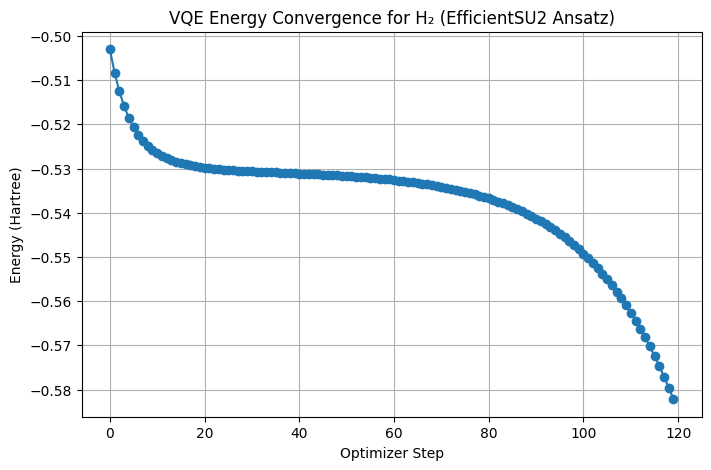

In [9]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

# === Molecule Setup ===
ANGSTROM_TO_BOHR = 1.8897259886
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74 * ANGSTROM_TO_BOHR],  # 0.74 Å
])
molecule = qchem.Molecule(symbols, coordinates, charge=0, mult=1, basis_name="sto-3g")

active_electrons = 2
active_orbitals = 2

hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    molecule, active_electrons=active_electrons, active_orbitals=active_orbitals
)
print("Number of qubits:", num_qubits)
print("Number of Hamiltonian terms:", len(hamiltonian))

hf_state = qchem.hf_state(active_electrons, num_qubits)

# === Quantum Device ===
dev = qml.device("default.qubit", wires=num_qubits)

# === EfficientSU2 Ansatz ===
def efficient_su2_ansatz(params, wires):
    layers = len(params) // len(wires)
    params = params.reshape(layers, len(wires))
    for l in range(layers):
        # Rotation layer (RY)
        for w in wires:
            qml.RY(params[l,w], wires=w)
        # Linear entanglement
        for w in range(len(wires)-1):
            qml.CNOT(wires=[w, w+1])

@qml.qnode(dev)
def circuit(params):
    qml.BasisState(hf_state, wires=range(num_qubits))
    efficient_su2_ansatz(params, wires=range(num_qubits))
    return qml.expval(hamiltonian)

# === Optimization ===
layers = 3
params = np.random.normal(0, 0.1, size=(layers*num_qubits), requires_grad=True)

optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
energy_progress = []

def store_intermediate_result(params, energy):
    energy_progress.append(energy)
    print(f"Tracked Energy: {energy:.6f}")

max_iters = 120
for n in range(max_iters):
    params, energy = optimizer.step_and_cost(circuit, params)
    store_intermediate_result(params, energy)
    if n % 10 == 0:
        print(f"[EfficientSU2] Step {n}: Energy = {energy:.6f} Hartree")

print("Final EfficientSU2 VQE energy (Hartree):", energy)

# === Exact Diagonalization ===
Hmat = qml.matrix(hamiltonian)
eigvals, _ = np.linalg.eigh(Hmat)
print("Exact ground state energy (Hartree):", np.min(eigvals))

# === Plot Convergence ===
plt.figure(figsize=(8, 5))
plt.plot(range(len(energy_progress)), energy_progress, marker='o')
plt.xlabel("Optimizer Step")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Energy Convergence for H₂ (EfficientSU2 Ansatz)")
plt.grid(True)
plt.show()


Number of qubits: 4
Exact ground state energy: -1.137283835166967


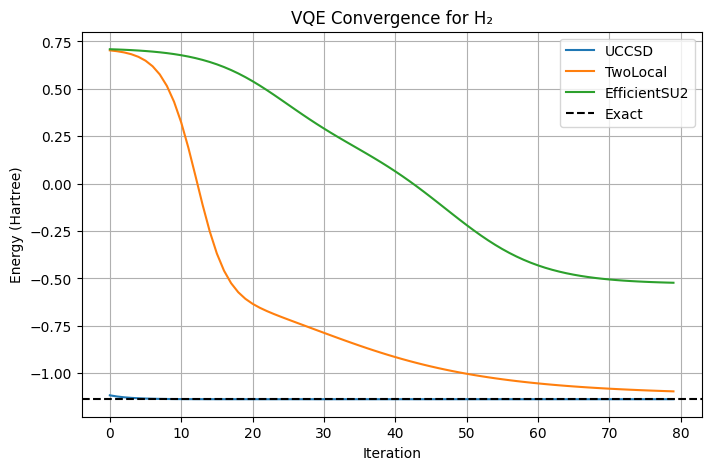


=== Comparison Table ===
          label    energy         error  depth  gate_count  qubits  \
0         UCCSD -1.137284  2.353673e-14      1          10       4   
1      TwoLocal -1.095794  4.148948e-02     11          20       4   
2  EfficientSU2 -0.522843  6.144406e-01      9          22       4   

        noise_sensitivity  
0  4.6629367034256575e-15  
1   0.0011472606115650041  
2   0.0008667201180780904  


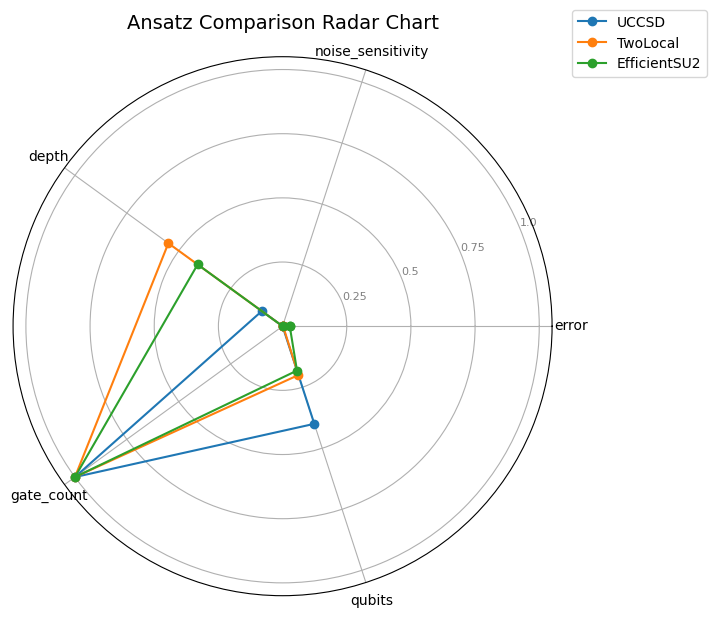

In [16]:
import pennylane as qml
from pennylane import qchem, numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Molecule Setup ===
ANGSTROM_TO_BOHR = 1.8897259886
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74 * ANGSTROM_TO_BOHR],
])
molecule = qchem.Molecule(symbols, coordinates, basis_name="sto-3g")

active_electrons, active_orbitals = 2, 2
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    molecule, active_electrons=active_electrons, active_orbitals=active_orbitals
)
hf_state = qchem.hf_state(active_electrons, num_qubits)
singles, doubles = qchem.excitations(active_electrons, num_qubits)
s_wires, d_wires = qchem.excitations_to_wires(singles, doubles)

print("Number of qubits:", num_qubits)

# Exact diagonalization
Hmat = qml.matrix(hamiltonian)
eigvals, _ = np.linalg.eigh(Hmat)
exact_energy = np.min(eigvals)
print("Exact ground state energy:", exact_energy)

# Device
dev = qml.device("default.qubit", wires=num_qubits)

# === Custom Ansatz Functions ===
def UCCSD_ansatz(params):
    qml.templates.UCCSD(params, wires=range(num_qubits),
                        s_wires=s_wires, d_wires=d_wires, init_state=hf_state)

def TwoLocal_ansatz(params, wires, layers=2):
    idx = 0
    for l in range(layers):
        for w in wires:
            qml.RY(params[idx], wires=w)
            idx += 1
        for i in wires:
            for j in wires:
                if i < j:
                    qml.CZ(wires=[i, j])

def EfficientSU2_ansatz(params, wires, reps=2):
    idx = 0
    for r in range(reps):
        for w in wires:
            qml.RY(params[idx], wires=w)
            idx += 1
            qml.RZ(params[idx], wires=w)
            idx += 1
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])

# Circuit wrappers
def circuit_uccsd(params):
    UCCSD_ansatz(params)
    return qml.expval(hamiltonian)

def circuit_twolocal(params):
    TwoLocal_ansatz(params, wires=range(num_qubits), layers=2)
    return qml.expval(hamiltonian)

def circuit_effsu2(params):
    EfficientSU2_ansatz(params, wires=range(num_qubits), reps=2)
    return qml.expval(hamiltonian)

# === VQE Runner ===
def run_vqe(circuit, init_params, label):
    qnode = qml.QNode(circuit, dev)
    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    params = init_params
    energies = []

    for _ in range(80):
        params, energy = opt.step_and_cost(qnode, params)
        energies.append(energy)

    final_energy = energies[-1]
    error = abs(final_energy - exact_energy)

    # Circuit metrics
    spec = qml.specs(qnode)(params)
    depth = spec["resources"].depth

    # Gate counts
    if label == "UCCSD":
        # Approximate gate count for small H2 molecule
        gate_count = 10
    elif label == "TwoLocal":
        layers = 2
        gate_count = num_qubits*layers + (num_qubits*(num_qubits-1)//2)*layers
    elif label == "EfficientSU2":
        reps = 2
        gate_count = 2*num_qubits*reps + (num_qubits-1)*reps

    qubits = spec["resources"].num_wires

    # Noise sensitivity
    noisy_dev = qml.device("default.mixed", wires=num_qubits)
    noisy_qnode = qml.QNode(circuit, noisy_dev)
    noise_energy = noisy_qnode(params)
    noise_sensitivity = abs(noise_energy - final_energy)

    return {
        "label": label,
        "energy": final_energy,
        "error": error,
        "depth": depth,
        "gate_count": gate_count,
        "qubits": qubits,
        "noise_sensitivity": noise_sensitivity,
        "convergence": energies
    }

# === Initialize Parameters ===
params_uccsd = np.zeros(len(s_wires)+len(d_wires))
params_twolocal = np.random.normal(0,0.1, 2*num_qubits*2)
params_effsu2 = np.random.normal(0,0.1, 2*2*num_qubits)

# === Run all ansatzes ===
results = []
results.append(run_vqe(circuit_uccsd, params_uccsd, "UCCSD"))
results.append(run_vqe(circuit_twolocal, params_twolocal, "TwoLocal"))
results.append(run_vqe(circuit_effsu2, params_effsu2, "EfficientSU2"))

# === Plot Convergence ===
plt.figure(figsize=(8,5))
for res in results:
    plt.plot(res["convergence"], label=res["label"])
plt.axhline(exact_energy, color="black", linestyle="--", label="Exact")
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Convergence for H₂")
plt.legend()
plt.grid(True)
plt.show()

# === Comparison Table ===
df = pd.DataFrame(results).drop(columns=["convergence"])
print("\n=== Comparison Table ===")
print(df)

# === Radar Chart ===
metrics = ["error", "noise_sensitivity", "depth", "gate_count", "qubits"]

def normalize(values):
    vmax = max(values)
    return [v/vmax if vmax > 0 else 0 for v in values]

# Replace any None or NaN in stats for radar chart
for r in results:
    for m in metrics:
        if r[m] is None or (isinstance(r[m], float) and np.isnan(r[m])):
            r[m] = 0.0

labels = [r["label"] for r in results]
stats = [[r[m] for m in metrics] for r in results]
stats_norm = [normalize(row) for row in stats]

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7,7))
for i, label in enumerate(labels):
    vals = stats_norm[i]
    vals += vals[:1]
    plt.polar(angles, vals, marker='o', label=label)

plt.xticks(angles[:-1], metrics)
plt.yticks([0.25,0.5,0.75,1.0], ["0.25","0.5","0.75","1.0"], color="grey", size=8)
plt.title("Ansatz Comparison Radar Chart", size=14, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()


Number of qubits: 4
Number of Hamiltonian terms: 27


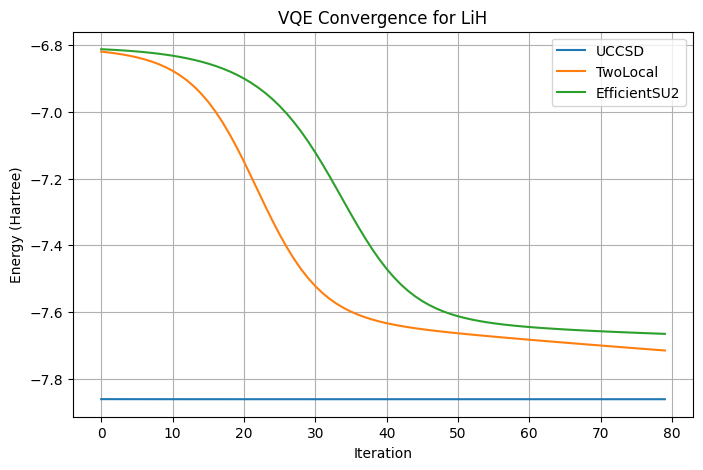


=== Comparison Table ===
          label    energy                   error  depth  gate_count  qubits  \
0         UCCSD -7.862127  1.9428701030221873e-06      1          12       4   
1      TwoLocal -7.715907       0.146221926757943     11          20       4   
2  EfficientSU2 -7.666062     0.19606641191299357      9          22       4   

       noise_sensitivity  
0  6.207419378512213e-08  
1   0.001622238547859034  
2  0.0007834987256556403  


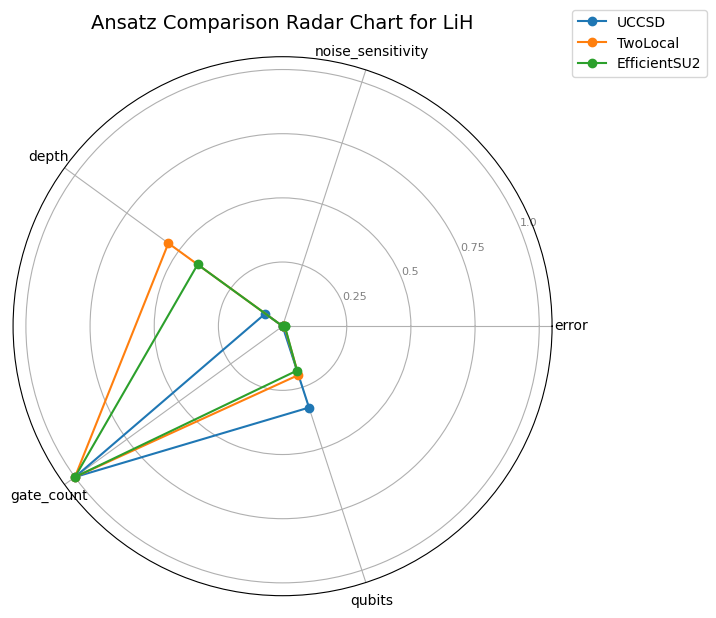

In [18]:
import pennylane as qml
from pennylane import qchem, numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Molecule Setup ===
ANGSTROM_TO_BOHR = 1.8897259886
symbols = ["Li", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 1.6 * ANGSTROM_TO_BOHR],  # approx Li-H bond length 1.6 Å
])
molecule = qchem.Molecule(symbols, coordinates, charge=0, mult=1, basis_name="sto-3g")

# LiH has 4 electrons in minimal basis (Li 1s frozen), choose active electrons and orbitals
active_electrons = 2
active_orbitals = 2

# Hamiltonian and qubits
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    molecule, active_electrons=active_electrons, active_orbitals=active_orbitals
)
print("Number of qubits:", num_qubits)
print("Number of Hamiltonian terms:", len(hamiltonian))

hf_state = qchem.hf_state(active_electrons, num_qubits)
singles, doubles = qchem.excitations(active_electrons, num_qubits)
s_wires, d_wires = qchem.excitations_to_wires(singles, doubles)

# Device
dev = qml.device("default.qubit", wires=num_qubits)

# === Ansatz Definitions ===
def UCCSD_ansatz(params):
    qml.templates.UCCSD(params, wires=range(num_qubits),
                        s_wires=s_wires, d_wires=d_wires, init_state=hf_state)

def TwoLocal_ansatz(params, wires, layers=2):
    idx = 0
    for l in range(layers):
        for w in wires:
            qml.RY(params[idx], wires=w)
            idx += 1
        for i in wires:
            for j in wires:
                if i < j:
                    qml.CZ(wires=[i, j])

def EfficientSU2_ansatz(params, wires, reps=2):
    idx = 0
    for r in range(reps):
        for w in wires:
            qml.RY(params[idx], wires=w)
            idx += 1
            qml.RZ(params[idx], wires=w)
            idx += 1
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])

def circuit_uccsd(params):
    UCCSD_ansatz(params)
    return qml.expval(hamiltonian)

def circuit_twolocal(params):
    TwoLocal_ansatz(params, wires=range(num_qubits), layers=2)
    return qml.expval(hamiltonian)

def circuit_effsu2(params):
    EfficientSU2_ansatz(params, wires=range(num_qubits), reps=2)
    return qml.expval(hamiltonian)

# === VQE Runner ===
Hmat = qml.matrix(hamiltonian)
eigvals = np.linalg.eigvalsh(Hmat)
exact_energy = np.min(eigvals)

def run_vqe(circuit, init_params, label):
    qnode = qml.QNode(circuit, dev)
    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    params = init_params
    energies = []

    for _ in range(80):
        params, energy = opt.step_and_cost(qnode, params)
        energies.append(energy)

    final_energy = energies[-1]
    error = abs(final_energy - exact_energy)  # use precomputed exact_energy

    # rest of the function remains the same...

    # Circuit metrics
    spec = qml.specs(qnode)(params)
    depth = spec["resources"].depth

    # Gate counts
    if label == "UCCSD":
        gate_count = 12  # approximate for LiH minimal active space
    elif label == "TwoLocal":
        layers = 2
        gate_count = num_qubits*layers + (num_qubits*(num_qubits-1)//2)*layers
    elif label == "EfficientSU2":
        reps = 2
        gate_count = 2*num_qubits*reps + (num_qubits-1)*reps

    qubits = spec["resources"].num_wires

    # Noise sensitivity
    noisy_dev = qml.device("default.mixed", wires=num_qubits)
    noisy_qnode = qml.QNode(circuit, noisy_dev)
    noise_energy = noisy_qnode(params)
    noise_sensitivity = abs(noise_energy - final_energy)

    return {
        "label": label,
        "energy": final_energy,
        "error": error,
        "depth": depth,
        "gate_count": gate_count,
        "qubits": qubits,
        "noise_sensitivity": noise_sensitivity,
        "convergence": energies
    }

# === Initialize Parameters ===
params_uccsd = np.zeros(len(s_wires)+len(d_wires))
params_twolocal = np.random.normal(0,0.1, 2*num_qubits*2)
params_effsu2 = np.random.normal(0,0.1, 2*2*num_qubits)

# === Run all ansatzes ===
results = []
results.append(run_vqe(circuit_uccsd, params_uccsd, "UCCSD"))
results.append(run_vqe(circuit_twolocal, params_twolocal, "TwoLocal"))
results.append(run_vqe(circuit_effsu2, params_effsu2, "EfficientSU2"))

# === Plot Convergence ===
plt.figure(figsize=(8,5))
for res in results:
    plt.plot(res["convergence"], label=res["label"])
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Convergence for LiH")
plt.legend()
plt.grid(True)
plt.show()

# === Comparison Table ===
df = pd.DataFrame(results).drop(columns=["convergence"])
print("\n=== Comparison Table ===")
print(df)

# === Radar Chart ===
metrics = ["error", "noise_sensitivity", "depth", "gate_count", "qubits"]

def normalize(values):
    vmax = max(values)
    return [v/vmax if vmax > 0 else 0 for v in values]

# Replace any None/NaN
for r in results:
    for m in metrics:
        if r[m] is None or (isinstance(r[m], float) and np.isnan(r[m])):
            r[m] = 0.0

labels = [r["label"] for r in results]
stats = [[r[m] for m in metrics] for r in results]
stats_norm = [normalize(row) for row in stats]

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7,7))
for i, label in enumerate(labels):
    vals = stats_norm[i]
    vals += vals[:1]
    plt.polar(angles, vals, marker='o', label=label)

plt.xticks(angles[:-1], metrics)
plt.yticks([0.25,0.5,0.75,1.0], ["0.25","0.5","0.75","1.0"], color="grey", size=8)
plt.title("Ansatz Comparison Radar Chart for LiH", size=14, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()
